In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/panoptic

/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic


In [ ]:
!pip install pycocotools

In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 53.8 MB/s eta 0:00:00


U ovoj svesci je radjeno na treniranju podataka koriscenjem Mask RCNN modela.

## Pregled Podataka

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic'

In [ ]:
!ls codes/utils/

utils.py


In [4]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
import cv2
from pycocotools.coco import COCO
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import ResNet50_Weights
from codes.utils.utils import plot_object_distribution, set_seed, save_model_weights, load_model_weights_and_optimizer, visualize_metrics
import albumentations as A
from codes.mask_rcnn.augmented_set import DatasetAugs
from datetime import datetime
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
TRAIN_ANNOTATION = './archive/train_val_test_new/coco_training.json'
VAL_ANNOTATION = './archive/train_val_test_new/coco_val.json'
TEST_ANNOTATION = './archive/train_val_test_new/coco_test.json'
IMAGES_DIR = './archive/images/'
MODEL_DIR_PATH = './output/mask_rcnn_models/'

In [6]:
NUM_CLASSES = 8
SEED = 42
set_seed(SEED)
device = 'cuda'

categories = {
    1: "Player",
    2: "Ball",
    3: "Goal Line",
    4: "Field",
    5: "Background",
    6: "Referee",
    7: "Football Pitch Line",
}

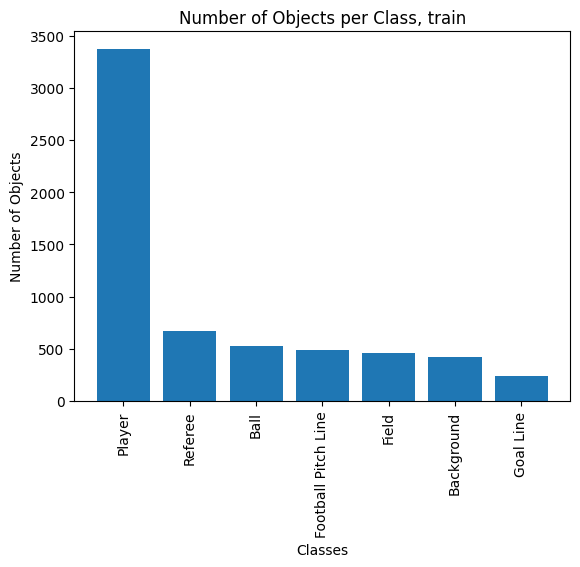

In [ ]:
plot_object_distribution(TRAIN_ANNOTATION, title = "Number of Objects per Class, train")

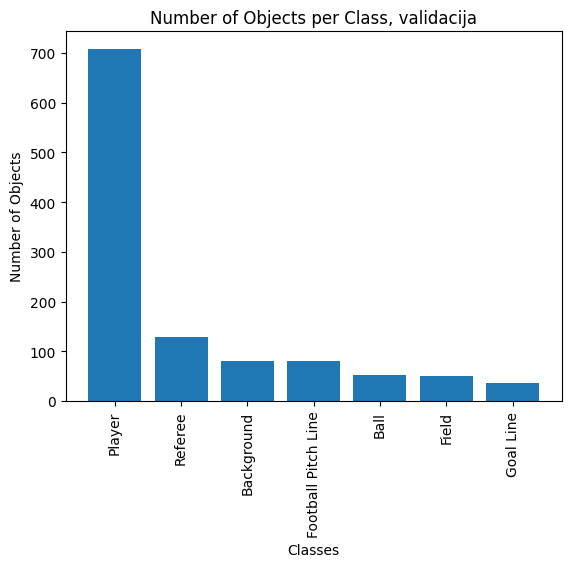

In [ ]:
plot_object_distribution(VAL_ANNOTATION, "Number of Objects per Class, validacija")

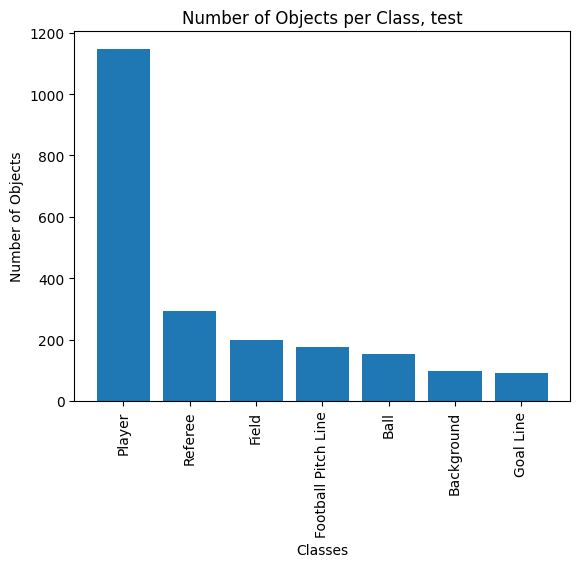

In [ ]:
plot_object_distribution(TEST_ANNOTATION, "Number of Objects per Class, test")

## Definisanje modela

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root, annotation_files, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco_datasets = [COCO(annotation_file) for annotation_file in annotation_files]
        self.img_ids = []
        for coco in self.coco_datasets:
            self.img_ids.extend(list(coco.imgs.keys()))
        self.img_ids = list(set(self.img_ids))


    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        for coco in self.coco_datasets:
            if img_id in coco.imgs:
                img_info = coco.loadImgs(img_id)[0]
                ann_ids = coco.getAnnIds(imgIds=img_id)
                anns = coco.loadAnns(ann_ids)
                break

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        masks = []
        areas = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            mask = coco.annToMask(ann)
            masks.append(mask)
            areas.append(ann['area'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        image_id = torch.tensor([img_id])
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in anns], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)



In [8]:
# small objects
def get_instance_segmentation_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', weights=ResNet50_Weights.IMAGENET1K_V1)

    anchor_generator = AnchorGenerator(
        sizes=(
            (4, 8, 16),    # P2 - High-resolution feature map for small objects
            (8, 16, 32),   # P4
            (16, 32, 64),  # P5
            (32, 64, 128),  # P6
            (128, 256, 512)
        ),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        rpn_pre_nms_top_n_train=4000,  # Increased from 2000
        rpn_post_nms_top_n_train=2000, # Increased from 1000
        rpn_pre_nms_top_n_test=2000,   # Increased from 1000
        rpn_post_nms_top_n_test=1000   # Increased from 500
    )

    return model


## Treniranje modela

In [9]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, data_loader, device, num_classes = NUM_CLASSES, testing = False):
    model.to(device)
    total_loss = 0.0
    num_batches = 0
    map_bbox = MeanAveragePrecision(iou_type="bbox", class_metrics=True)
    mAP_70_res = None

    if testing:
      map_70 = MeanAveragePrecision(iou_thresholds=[0.7, 0.8, 0.9], class_metrics=True)

    with torch.no_grad():
        for images, targets in data_loader:
            model.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images, targets)


            loss_dict = outputs
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            num_batches += 1

            model.eval()
            outputs = model(images)


            for i, output in enumerate(outputs):

                preds = [{
                    'boxes': outputs[i]['boxes'].cpu(),
                    'scores': outputs[i]['scores'].cpu(),
                    'labels': outputs[i]['labels'].cpu(),
                }]

                gts = [{
                    'boxes': targets[i]['boxes'].cpu(),
                    'labels': targets[i]['labels'].cpu(),
                }]

                map_bbox.update(preds, gts)

                if testing:
                      map_70.update(preds, gts)

    mean_loss = total_loss / num_batches if num_batches > 0 else float('nan')
    mAP_bbox_res = map_bbox.compute()

    print(f"lopta: { mAP_bbox_res['map_per_class'][1] }")

    if testing:
      mAP_70_res = map_70.compute()

    return mean_loss, mAP_bbox_res, mAP_70_res

In [10]:
def train(model, train_loader, val_loader, optimizer, lr_scheduler = None, num_epochs = 5, save_checkpoint_path = None):
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    device = 'cuda'

    train_losses = []
    val_losses = []
    map_values_bbox = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch loss: {epoch_loss}")
        train_losses.append(epoch_loss)

        torch.cuda.empty_cache()

        val_epoch_loss, val_mAP_bbox, _ = evaluate(model, val_loader, device)
        val_mAP_bbox = val_mAP_bbox['map']
        print(f"Validation loss: {val_epoch_loss}\nValidation bbox mAP: {val_mAP_bbox}")

        map_values_bbox.append(val_mAP_bbox)
        val_losses.append(val_epoch_loss)
        if lr_scheduler:
            lr_scheduler.step()
        torch.cuda.empty_cache()

        if save_checkpoint_path != None:
          save_model_weights(model, optimizer, MODEL_DIR_PATH, f'{epoch}_{datetime.now().strftime("%Y.%m.%d_%H.%M.%S")}')


    print("Training complete")
    return model, train_losses, val_losses, map_values_bbox

In [12]:
def test(model, device, test_loader, class_names = None):
    mean_loss, mAP, map_70 = evaluate(model, test_loader, device)

    visualize_metrics(mAP, categories)

In [13]:
def plot_losses(train_losses, val_losses):
    epochs = [i for i in range(1, len(val_losses)+1)]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs - MASK RCNN')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()

In [14]:
train_dataset = CustomDataset(IMAGES_DIR, [
    TRAIN_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

val_dataset = CustomDataset(IMAGES_DIR, [
    VAL_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=2.87s)
creating index...
index created!
loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


In [ ]:
len(train_dataset)

567

In [15]:
model = get_instance_segmentation_model(NUM_CLASSES)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
num_epochs = 10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 48.2MB/s]


In [ ]:
model, train_losses, val_losses, map_values_bbox  = train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs, save_checkpoint_path=MODEL_DIR_PATH)

Epoch 1/10
Epoch loss: 1.1424361097980553
lopta: 0.0
Validation loss: 1.0310467272996902
Validation bbox mAP: 0.07389736920595169
Model i optimizer sačuvani u: ./output/mask_rcnn_models/0_2024.09.25_13.58.54.pth
Epoch 2/10
Epoch loss: 0.9302481182024512
lopta: 0.0
Validation loss: 1.0388117209076881
Validation bbox mAP: 0.2610134482383728
Model i optimizer sačuvani u: ./output/mask_rcnn_models/1_2024.09.25_14.03.15.pth
Epoch 3/10
Epoch loss: 0.8206325778868836
lopta: 0.0766133964061737
Validation loss: 0.994417917728424
Validation bbox mAP: 0.31933289766311646
Model i optimizer sačuvani u: ./output/mask_rcnn_models/2_2024.09.25_14.07.36.pth
Epoch 4/10
Epoch loss: 0.71830576700224
lopta: 0.23487861454486847
Validation loss: 0.962468983232975
Validation bbox mAP: 0.43535152077674866
Model i optimizer sačuvani u: ./output/mask_rcnn_models/3_2024.09.25_14.11.59.pth
Epoch 5/10
Epoch loss: 0.6303842873640464
lopta: 0.2919139862060547
Validation loss: 0.8568423002958298
Validation bbox mAP: 0

Ucitavanje modela.

In [21]:
load_model_weights_and_optimizer(model, optimizer, MODEL_DIR_PATH, '5_2024.09.26_22.13.17')

/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic/codes/utils/utils.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.

Model i optimizer učitani iz: ./output/mask_rcnn_models/5_2024.09.26_22.13.17.pth


(MaskRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       Resize(min_size=(800,), max_size=1333, mode='bilinear')
   )
   (backbone): BackboneWithFPN(
     (body): IntermediateLayerGetter(
       (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (bn1): FrozenBatchNorm2d(64, eps=1e-05)
       (relu): ReLU(inplace=True)
       (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (layer1): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): FrozenBatchNorm2d(64, eps=1e-05)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): FrozenBatchNorm2d(64, eps=1e-05)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn3): FrozenBatchNorm2d(256, eps=1e-05

In [ ]:
from codes.utils.utils import save_model

save_model(
    model,
    optimizer,
    val_losses,
    train_losses,
    optimizer.param_groups[0]['lr'],
    num_epochs,
    train_loader.batch_size,
    str(model),
    MODEL_DIR_PATH,
    len(train_loader.dataset),
    len(val_loader.dataset),
    [tensor.item() if tensor.numel() == 1 else tensor.tolist() for tensor in map_values_bbox],
    'mask_rcnn_fpn_step_size_change',
    'ResNet50',
    optimizer_hyperparameters=str(optimizer.defaults),
    seed=SEED,
    mention = "Promena parametra optimizatora, resavamo problem preuranjene konvergencije."
)

Metapodaci sačuvani u: ./output/mask_rcnn_models/mask_rcnn_fpn_step_size_change.json
Model i optimizer sačuvani u: ./output/mask_rcnn_models/mask_rcnn_fpn_step_size_change.pth


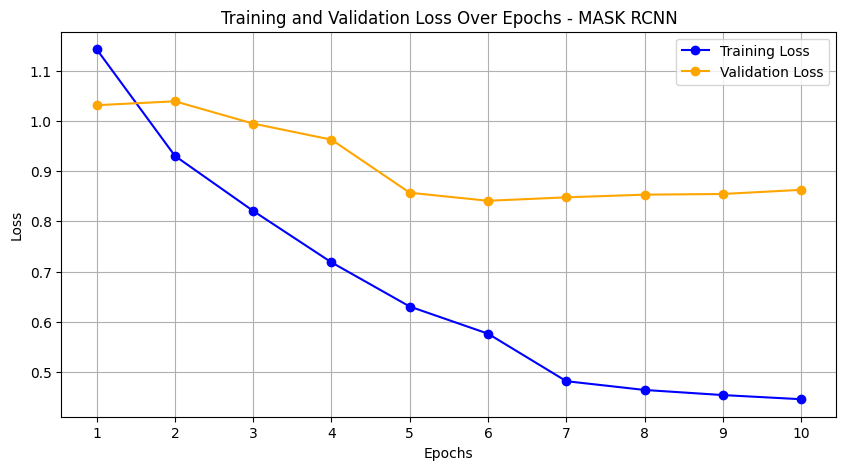

In [ ]:
plot_losses(train_losses, val_losses)

Proveravamo rezultate koje smo dobili na validacionom skupu.

lopta: 0.5132282376289368
Ukupne metrike:
Metrička vrednost       Vrednost
              map tensor(0.6669)
           map_50 tensor(0.9028)
           map_75 tensor(0.7390)
        map_small tensor(0.2595)
       map_medium tensor(0.4288)
        map_large tensor(0.7137)
            mar_1 tensor(0.5398)
           mar_10 tensor(0.7091)
          mar_100 tensor(0.7278)
        mar_small tensor(0.2819)
       mar_medium tensor(0.4872)
        mar_large tensor(0.7648)

Metrike po klasama:
 ID klase               Klasa    map  mar_100
        1              Player 0.6089   0.6742
        2                Ball 0.5132   0.5519
        3           Goal Line 0.7487   0.8083
        4               Field 0.9066   0.9300
        5          Background 0.9092   0.9825
        6             Referee 0.6385   0.7349
        7 Football Pitch Line 0.3429   0.4125


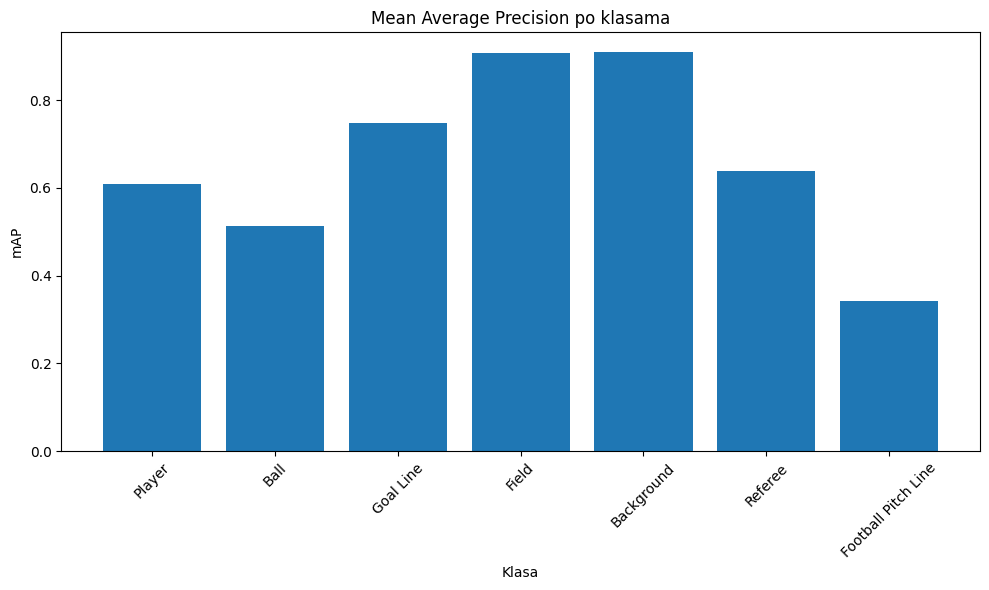

In [22]:
test(model, 'cuda', val_loader)

## Testiranje modela

Konacnu evaluaciju modela vrsimo nad test skupom.

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
lopta: 0.42468076944351196
Ukupne metrike:
Metrička vrednost       Vrednost
              map tensor(0.7041)
           map_50 tensor(0.9371)
           map_75 tensor(0.8293)
        map_small tensor(0.1416)
       map_medium tensor(0.4662)
        map_large tensor(0.7834)
            mar_1 tensor(0.5303)
           mar_10 tensor(0.7589)
          mar_100 tensor(0.7640)
        mar_small tensor(0.1732)
       mar_medium tensor(0.5073)
        mar_large tensor(0.8244)

Metrike po klasama:
 ID klase               Klasa    map  mar_100
        1              Player 0.6825   0.7499
        2                Ball 0.4247   0.5196
        3           Goal Line 0.7081   0.7484
        4               Field 0.9358   0.9470
        5          Background 0.9149   0.9444
        6             Referee 0.6076   0.7027
        7 Football Pitch Line 0.6549   0.7358


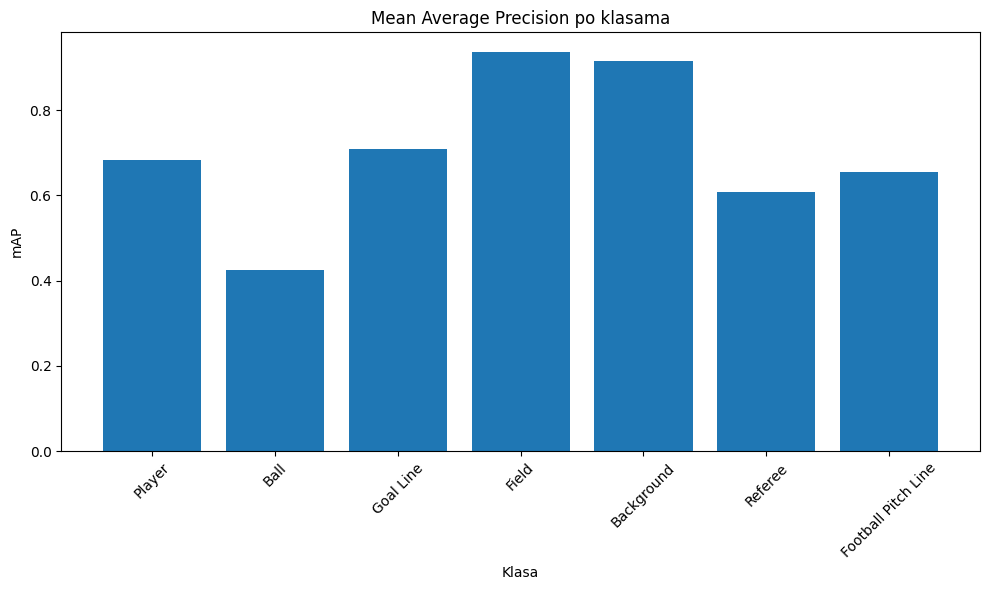

In [23]:
test_dataset = CustomDataset(IMAGES_DIR, [
    TEST_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

test(model, 'cuda', test_loader)

## Predikcije na pojedinacnim slikama

In [ ]:
# setting model priorities for properly mask drawing
priorities = {
    1 : 6, # player
    2 : 7, # ball
    3 : 4, # goal line
    4 : 2, # field
    5 : 1, # background
    6 : 5, # refree
    7 : 3, # pitch line
    0 : 0
}

In [ ]:
def predict(model, image_path, device):
    image = Image.open(image_path).convert("RGB")

    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        prediction = model(image_tensor.to(device))

    return image, prediction

In [ ]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn

In [ ]:
def set_priorities(prediction, priorities):
    predictions_with_priorities = []
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label_id = int(prediction[0]['labels'][element].cpu().numpy())
        mask = prediction[0]['masks'][element, 0].cpu().numpy()
        priority = priorities.get(label_id, 0)
        predictions_with_priorities.append((priority, box, score, label_id, mask))

    predictions_with_priorities.sort(key=lambda x: x[0])
    return predictions_with_priorities

def predict_and_visualize(image_path, model, device, draw_mask = True, draw_box = True):

    image, prediction = predict(model, image_path, device)

    predictions_with_priorities = set_priorities(prediction, priorities)

    combined_mask = np.zeros_like(image, dtype=np.float32)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    if draw_mask:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                mask = mask > 0.5
                random_color = np.random.rand(3)
                colored_mask = np.zeros((*mask.shape, 3))
                colored_mask[mask] = random_color
                combined_mask[mask] = random_color


        combined_mask = np.clip(combined_mask, 0, 1)
        ax.imshow(combined_mask, alpha=0.5)

    if draw_box:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1] - 10, f'{label}: {score:.2f}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

In [ ]:
predict_and_visualize("./archive/images/Football batch 3.mp4_00033.jpg", model, device, draw_box=True, draw_mask=True)

NameError: name 'predict_and_visualize' is not defined

## Prosirivanje skupa podataka

In [ ]:
width, height = 1920, 1080
# transformations_list
geom_transforms =  [A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=5,
                       interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),

                    A.HorizontalFlip(p=0.5),
                    A.RandomSizedCrop((800, 1070), height, width, w2h_ratio=1920/1080,
                                        interpolation=cv2.INTER_CUBIC, always_apply=False, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
                    ]

In [ ]:
augmented_train_dataset = DatasetAugs(IMAGES_DIR, [TRAIN_ANNOTATION], geom_transforms, size_factor = 2)
val_dataset = CustomDataset(IMAGES_DIR, [
    VAL_ANNOTATION
], transforms=T.Compose([T.ToTensor()]))

train_loader = DataLoader(augmented_train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=2.60s)
creating index...
index created!
loading annotations into memory...
Done (t=1.49s)
creating index...
index created!


In [ ]:
len(augmented_train_dataset)

1134

In [17]:
model = get_instance_segmentation_model(NUM_CLASSES)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
num_epochs = 10

In [ ]:
model, train_losses, val_losses, map_values_bbox  = train(model, train_loader, val_loader, optimizer, num_epochs = num_epochs, save_checkpoint_path=MODEL_DIR_PATH)

Epoch 1/10
Epoch loss: 1.0002628577427126
lopta: 0.0
Validation loss: 1.0759143203496933
Validation bbox mAP: 0.28802162408828735
Model i optimizer sačuvani u: ./output/mask_rcnn_models/0_2024.09.26_21.31.24.pth
Epoch 2/10
Epoch loss: 0.7865523705914826
lopta: 0.35549047589302063
Validation loss: 0.8035550713539124
Validation bbox mAP: 0.4880657196044922
Model i optimizer sačuvani u: ./output/mask_rcnn_models/1_2024.09.26_21.39.44.pth
Epoch 3/10
Epoch loss: 0.6688689387495249
lopta: 0.37221094965934753
Validation loss: 0.7628885746002197
Validation bbox mAP: 0.5964803099632263
Model i optimizer sačuvani u: ./output/mask_rcnn_models/2_2024.09.26_21.48.06.pth
Epoch 4/10
Epoch loss: 0.5993109358553316
lopta: 0.49828654527664185
Validation loss: 0.8588109210133552
Validation bbox mAP: 0.5681264400482178
Model i optimizer sačuvani u: ./output/mask_rcnn_models/3_2024.09.26_21.56.28.pth
Epoch 5/10
Epoch loss: 0.5476997083341572
lopta: 0.40939995646476746
Validation loss: 0.7742121562361717
Va

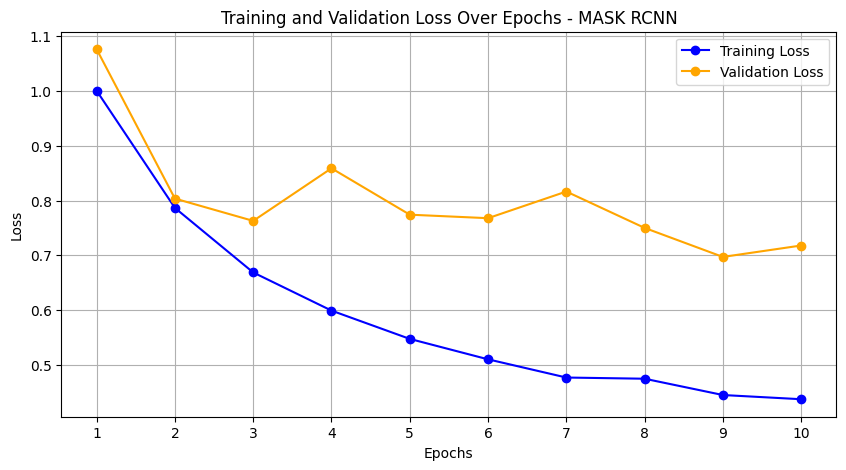

In [ ]:
plot_losses(train_losses, val_losses)

lopta: 0.44012317061424255
Ukupne metrike:
Metrička vrednost       Vrednost
              map tensor(0.5843)
           map_50 tensor(0.8870)
           map_75 tensor(0.5841)
        map_small tensor(0.2204)
       map_medium tensor(0.4023)
        map_large tensor(0.6295)
            mar_1 tensor(0.4625)
           mar_10 tensor(0.6376)
          mar_100 tensor(0.6541)
        mar_small tensor(0.2510)
       mar_medium tensor(0.4678)
        mar_large tensor(0.6917)

Metrike po klasama:
 ID klase               Klasa    map  mar_100
        1              Player 0.5660   0.6431
        2                Ball 0.4401   0.5019
        3           Goal Line 0.5398   0.5639
        4               Field 0.7453   0.8040
        5          Background 0.8462   0.9625
        6             Referee 0.6085   0.7171
        7 Football Pitch Line 0.3438   0.3862


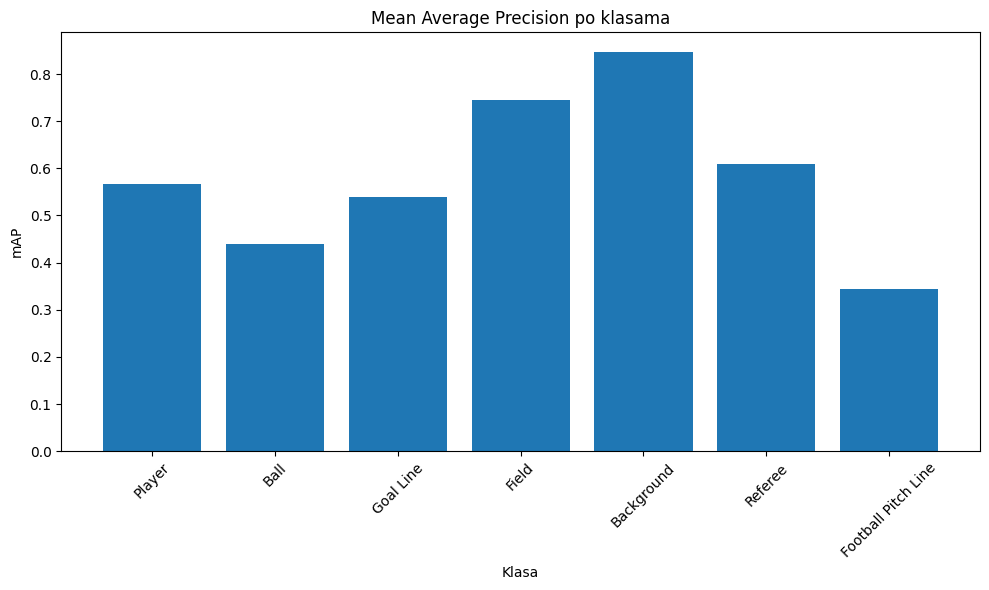

In [ ]:
test(model, 'cuda', val_loader)

In [ ]:
from codes.utils.utils import save_model

save_model(
    model,
    optimizer,
    val_losses,
    train_losses,
    optimizer.param_groups[0]['lr'],
    num_epochs,
    train_loader.batch_size,
    str(model),
    MODEL_DIR_PATH,
    len(train_loader.dataset),
    len(val_loader.dataset),
    [tensor.item() if tensor.numel() == 1 else tensor.tolist() for tensor in map_values_bbox],
    'mask_rcnn_augm_adam',
    'ResNet50',
    optimizer_hyperparameters=str(optimizer.defaults),
    seed=SEED,
    mention = "Promena optimizatora, koriscen adam."
)

Metapodaci sačuvani u: ./output/mask_rcnn_models/mask_rcnn_augm_adam.json
Model i optimizer sačuvani u: ./output/mask_rcnn_models/mask_rcnn_augm_adam.pth
